# Qualitative Comparison

## Imports

In [1]:
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

## Swarm Map

In [2]:
# Agent config
num_agents = 400
agent_radius = 0.4

# Map config
map_type = "swarm" # Available maps: empty, corridor, obstacle, cross
num_samples = 100 # Available num_samples: 100, 200, 300, 400, 500

# config starts and goals

start_regions = [
    Polygon([[0, 40], [0, 0], [50, 0], [50, 40]]),
    Polygon([[0, 160], [0, 120], [50, 120], [50, 160]])
]
# 
goal_regions = [
    Polygon([[160, 160], [160, 110], [200, 110], [200, 160]]),
    Polygon([[160, 40], [160, 0], [200, 0], [200, 40]]),
]

num_starts = 12
num_goals = 12


In [3]:
# Curated Example
# num_agents = 400
# starts_idx = [30, 20, 73, 88, 56] 
# goals_idx = [71, 12, 43, 50, 45]
# starts_agent_count = [72, 92, 66, 73, 97] 
# goals_agent_count = [74, 92, 79, 70, 85]

## Obstacle Map

In [4]:
# Agent config
num_agents = 200
agent_radius = 0.1

# Map config
map_type = "obstacle" # Available maps: empty, corridor, obstacle, cross
num_samples = 100 # Available num_samples: 100, 200, 300, 400, 500

# config starts and goals

start_regions = [
    Polygon([[0, 40], [0, 0], [50, 0], [50, 40]]),
    Polygon([[0, 160], [0, 120], [50, 120], [50, 160]])
]
# 
goal_regions = [
    Polygon([[170, 160], [170, 110], [200, 110], [200, 160]]),
    Polygon([[170, 40], [170, 0], [200, 0], [200, 40]]),
]

num_starts = 10
num_goals = 10


In [5]:
# Curated Example
 
# num_agents = 400
# starts_idx = [88, 32, 39, 63, 17, 75, 50, 9]
# goals_idx = [28, 11, 29, 26, 54, 30, 73, 45]
# starts_agent_count = [66, 56, 71, 74, 53, 58, 62, 60]
# goals_agent_count =  [74, 52, 63, 76, 52, 62, 64, 57]


## Visualize Instance

In [6]:
# Load map and instance
import os
import pickle
from collections import Counter

import numpy as np 

map_fname = "{}_{}.pkl".format(map_type, num_samples)
fname = os.path.join("../maps", map_fname)
with open(fname, "rb") as f:
    gaussian_prm = pickle.load(f) 

node_capacities = [g_node.get_capacity(agent_radius) for g_node in gaussian_prm.gaussian_nodes]
print("average node capacity: ", np.average(node_capacities))

# Randomly choose starts and goals from the candidates, and assign them a weight
# Make sure all agents can fit in the start and goal configuration

starts_idx_set = gaussian_prm.get_node_index(start_regions)
goals_idx_set = gaussian_prm.get_node_index(goal_regions)

starts_idx = np.random.choice(starts_idx_set, num_starts, replace=False).tolist()
goals_idx = np.random.choice(goals_idx_set, num_goals, replace=False).tolist()

# Create weight pool

starts_pool = []
goals_pool = []

for start_idx in starts_idx:
    starts_pool += [start_idx] * gaussian_prm.gaussian_nodes[start_idx].get_capacity(agent_radius)

for goal_idx in goals_idx:
    goals_pool += [goal_idx] * gaussian_prm.gaussian_nodes[goal_idx].get_capacity(agent_radius)

assert len(starts_pool) > num_agents, f"Not enough space in start config. Start capacity: {len(starts_pool)}"
assert len(goals_pool) > num_agents, f"Not enough space in goal config. Goal capacity: {len(goals_pool)}"

start_per_agent = np.random.choice(starts_pool, num_agents, replace=False).tolist()
goal_per_agent = np.random.choice(goals_pool, num_agents, replace=False).tolist()

start_counts = Counter(start_per_agent)
goal_counts = Counter(goal_per_agent)

starts_idx = []
starts_agent_count = []
goals_idx = []
goals_agent_count = []

for start_idx, count in start_counts.items():
    starts_idx.append(start_idx)
    starts_agent_count.append(count)

for goal_idx, count in goal_counts.items():
    goals_idx.append(goal_idx)
    goals_agent_count.append(count)

print(starts_idx, goals_idx)
print(starts_agent_count, goals_agent_count)

average node capacity:  2831.87
[63, 35, 61, 75, 32, 88, 39, 9, 50, 17] [30, 26, 29, 55, 28, 11, 44, 54, 46, 45]
[24, 20, 23, 20, 7, 21, 25, 23, 18, 19] [23, 19, 28, 19, 18, 17, 22, 19, 17, 18]


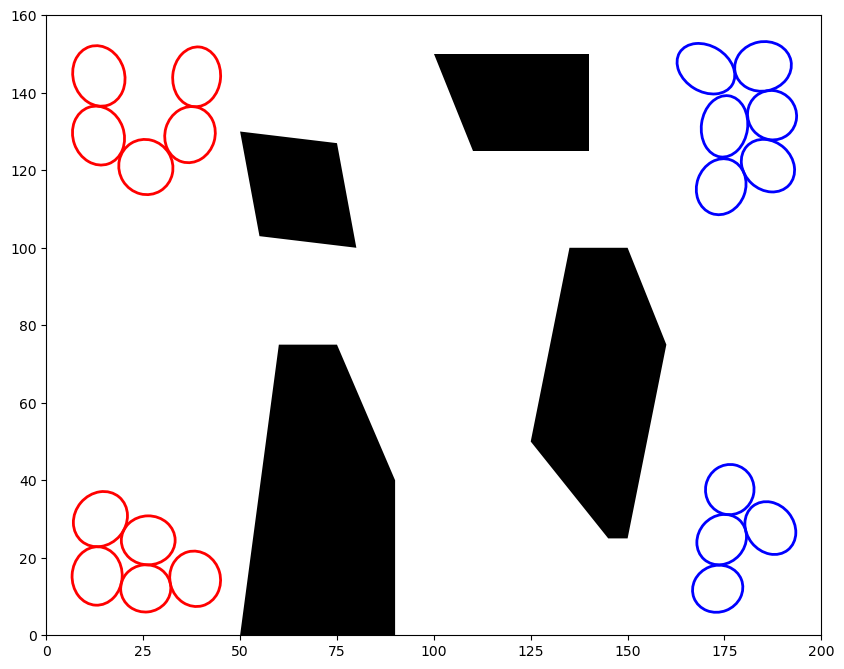

In [7]:
# Visualize instance
fig, ax = gaussian_prm.visualize_map()

for start in starts_idx:
    gaussian_prm.gaussian_nodes[start].visualize(ax)

for goal in goals_idx :
    gaussian_prm.gaussian_nodes[goal].visualize(ax, edgecolor="b")

plt.show()

## Run Solver

In [8]:
from swarm_prm.solvers.macro import SOLVER_REGISTRY
solver_name = "FormationControlSolver"
# solver_name = "LPSolver"
# solver_name = "TEGTwoStepSolver"

solver_cls = SOLVER_REGISTRY[solver_name]

solver = solver_cls(gaussian_prm, agent_radius, 
              starts_agent_count=starts_agent_count, goals_agent_count=goals_agent_count,
              starts_idx=starts_idx, goals_idx=goals_idx,
              num_agents=num_agents, time_limit=180)
solution = solver.solve()
assert solution["success"], "solver failed."
timestep = solution["timestep"]
paths = solution["paths"]
g_nodes = solution["g_nodes"]
candid_starts_idx = solution["starts_idx"]
candid_goals_idx = solution["goals_idx"]

num_violation, max_violation_percentage = solver.eval_capacity(solution["paths"])
print("num violation: ", num_violation)
print("max violation percentage: ", max_violation_percentage)
# ~83min for 500 agents on a graph with 16 timesteps, 3510 nodes in TEG. Running for 1000 iterations

num violation:  0
max violation percentage:  0


/opt/homebrew/Caskroom/miniforge/base/envs/SwarmPRM/lib/python3.12/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/opt/homebrew/Caskroom/miniforge/base/envs/SwarmPRM/lib/python3.12/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/opt/homebrew/Caskroom/miniforge/base/envs/SwarmPRM/lib/python3.12/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");
/opt/homebrew/Caskroom/miniforge/base/envs/SwarmPRM/lib/python3.12/site-packages/mosek/__init__.py:1861

In [9]:
print(paths)

[[0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 10], [0, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 11], [1, 20, 21, 12], [1, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 12], [2, 20, 21, 1

In [10]:
from matplotlib import pyplot as plt
from swarm_prm.utils import paths_to_macro
from swarm_prm.solvers.micro import EvaluationSolver

agent_radius = 0.9 # to guarantee that we have enough samples in each node for visualization

macro_solution = paths_to_macro(paths)

timestep = max(macro_solution.keys())

solver = EvaluationSolver(g_nodes, macro_solution, agent_radius, timestep, 
                                     num_agents, 
                                     candid_starts_idx,
                                     candid_goals_idx,
                                     starts_agent_count,
                                     goals_agent_count
                                    )

single_agent_paths, cost = solver.solve()
fig, ax = gaussian_prm.visualize_map()

cmap = plt.get_cmap("rainbow")
colors = [cmap(i / num_agents) for i in range(num_agents)]

for i, path in enumerate(single_agent_paths):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-', label='Path', color=colors[i], linewidth=0.8, alpha=0.5)

for start in starts_idx:
    gaussian_prm.gaussian_nodes[start].visualize(ax)

for goal in goals_idx:
    gaussian_prm.gaussian_nodes[goal].visualize(ax, edgecolor="b")

plt.show()

AssertionError: Not enough samples in the node. 58/200

## Visualize Per-agent Paths

In [ ]:
# Animate path
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

from IPython.display import Video

# Add interpolations 
import numpy as np

def add_linear_interpolation_points(path, subdiv=5):
    """
    Insert linearly-interpolated positions between consecutive points.
    
    Parameters
    ----------
    path : array-like of shape (N, 2)
        The original list/array of N 2D points, e.g. [(x1,y1), (x2,y2), ...].
    subdiv : int
        Number of intervals to subdivide each segment. 
        For each original segment, we will add 'subdiv - 1' new interior points 
        (except that we skip duplicates at the shared boundary).

    Returns
    -------
    new_path : np.ndarray of shape (M, 2)
        The new path including the original points and the added interpolation points.
    """
    path = np.asarray(path)
    new_path = []

    # Iterate over pairs of consecutive points
    for i in range(len(path) - 1):
        start = path[i]
        end = path[i + 1]
        
        # Create subdiv+1 points in [start, end] using linspace for each dimension
        xs = np.linspace(start[0], end[0], subdiv + 1)
        ys = np.linspace(start[1], end[1], subdiv + 1)
        
        # Add each intermediate point except the very last one
        # to avoid duplicating the next segment's start
        for j in range(subdiv):
            new_path.append([xs[j], ys[j]])

    # Finally add the very last point of the last segment
    new_path.append(path[-1].tolist())
    
    return np.array(new_path)

interpolated_paths = []
for p in single_agent_paths:
    new_path = add_linear_interpolation_points(p, 50)
    interpolated_paths.append(new_path)

def animate_solution(agent_radius, paths, fig, ax, fig_path="."):
    """
        Visualize solution trajectory provided instance
    """
    agents = []
    cmap = plt.get_cmap("tab10")
    
    for i in range(len(paths)):
        loc = paths[i][0]
        circle = Circle((loc[0], loc[1]), radius=agent_radius, color=cmap(i % 10))
        agents.append(circle)
        ax.add_patch(circle)

    def init():
        return agents

    def update(frame):
        for agent, traj in zip(agents, paths):
            agent.set_center(traj[frame])
        return agents

    anim = FuncAnimation(fig, update, frames=len(paths[0]), 
                         init_func=init, blit=True, interval=100)
    anim.save(f"{fig_path}/apf_solution.mp4", writer='ffmpeg', fps=24)
    plt.close()

fig_path = "solutions"
fig, ax = gaussian_prm.visualize_map()
animate_solution(agent_radius, interpolated_paths, fig, ax, fig_path=fig_path)
Video(filename="solutions/apf_solution.mp4", embed=True)

## APF


In [ ]:
# Simulate with APF
from swarm_prm.solvers.micro.apf import APFWaypointSolver
# 
apf_solver = APFWaypointSolver(gaussian_prm.obstacle_map, interpolated_paths, agent_radius,
                                attract_coeff=1,
                                agent_repel_coeff=0.001,
                                repel_coeff=0.1,
                                obs_thresh=1,
                                step_size=0.5,
                                reach_dist=5,
                                max_timestep_iter=200
                               )
paths = apf_solver.get_solution()

Found solution


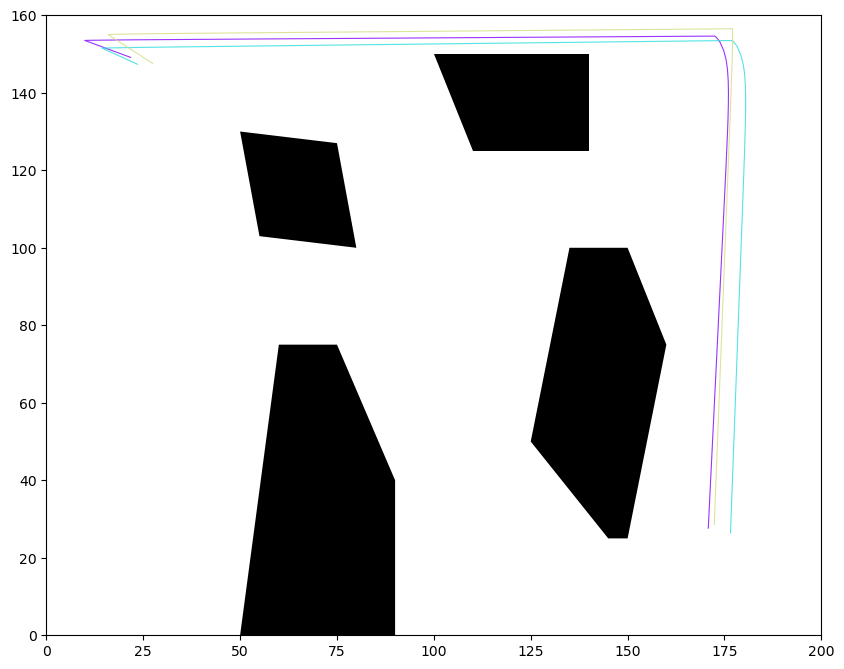

In [ ]:
fig, ax = gaussian_prm.visualize_map()
for i, path in enumerate(paths):
    x_coords = [loc[0] for loc in path]
    y_coords = [loc[1] for loc in path]
    ax.plot(x_coords, y_coords, '-', label='Path', color=colors[i], linewidth=0.8, alpha=0.8)

plt.show()